# Quantum gates with tunable couplers

In [1]:
using Random
using LinearAlgebra
using ITensors
using PastaQ
using Printf
using OptimKit: OptimKit
using Observers
using Plots
using Findpeaks
using PlotThemes
using DataFrames
import StatsBase: mean
using Zygote: bufferfrom
using ProgressMeter

import ITensors: op

## Setup

In [2]:
GHz = 2π
MHz = 1e-3 * GHz
KHz = 1e-6 * GHz
fF = 1e-6

theme(:dark)
colors = get_color_palette(:auto,17)
plot_args = (dpi=1000,size=(600,400), margin=5Plots.mm, marker = :circle, markersize = 3,linewidth = 1);

In [3]:
n = 4 
nthreads = Threads.nthreads()  
overflow = n % nthreads
states_per_thread = n÷nthreads
threadsset = [collect((x-1)*states_per_thread+1:x*states_per_thread) for x in 1:nthreads]
if overflow > 0 
    @assert overflow < nthreads
    for j in 1:overflow
        push!(threadsset[j], n-overflow+j)
    end 
end;

In [4]:
function op(::OpName"Rz", ::SiteType"Qudit", dim::Int; ϕ)
    dim == 2 && return gate("Rz"; ϕ = ϕ)
    dim == 3 && return [exp(im * ϕ / 2) 0.0  0.0
                            0.0  exp(-im * ϕ / 2) 0.0
                            0.0 0.0 0.0]
end;

## Transmon qubits

The quantum LC circuit is described the Hamiltonian $H = 4E_Cn^2 + \frac{1}{2}E_L\phi^2$, where $E_C=e^2/2C$ is the charging energy, $n=Q/2e$ is the reduced charge, $E_L\propto(\Phi_0/2\pi)^2/L$ is the inductive energy, $\phi=2\pi\Phi/\Phi_0$ is the reduced flux and $\Phi_0=h/2e$ is the magnetic flux quantum ($h=1$). It is well known that the above Hamiltonian can be represented in a more compact in second quantization:

$$H = \omega_r\left(a^\dagger a + \frac{1}{2}\right) $$

where $\omega_r = \sqrt{8E_LE_C}$ is the resonant frequency.

<img src="transmon.jpg" width=25% height=25%>

Image from : https://arxiv.org/abs/1904.06560 


A qubit is obtained by adding a non-linearity to such system, in a way that specific energu transitions can be driven without exciting other unwanted levels in the systems. One possible way to introduce anharmonicity is to replace the linear inductor with a Josephson junction, leading to a new Hamiltonian

$$ H = 4E_Cn^2-E_J\cos(\phi) $$

where the charging energy $E_C = e^2/2C_\Sigma$ is now expressed in terms of the total capacitance $C_\Sigma = C_s + C_J$ with shunt capacitance $C_s$ and self-capacitance $C_J$ (of the junction), and $E_J = I_c\Phi_0/2\pi$ is the junction energy (with $I_c$ being the critical current).

The behaviour of this non-linear system is dictated by the competition between $E_C$ and $E_J$. Here we will consider the regime of $E_J\gg E_C$, as the system is less sensitive to charge noise (which turns out to be harder to mitigate than flux noise). 

The Hamiltonian can be approximated with a Duffing oscillator:

$$ H = \omega a^\dagger a + \frac{\alpha}{2}a^\dagger a^\dagger a a $$

where $\omega = \sqrt{8E_CE_J} - E_C$ is the qubit frequency, and $\alpha = -E_C = \omega^{1\rightarrow2} - \omega^{0\rightarrow1}$ is the anharmonicity ($\alpha < 0$). Typicaly operating values are $\omega=3-6$GHz and $\alpha\approx150-200$MHz.

In practice, we often need to control the qubit frequency, such as to perform a quantum gate by bringing to qubit in resonance with each other. The above qubit model however does not allow to tune the frequency via external control. In order to achieve that, one can introduce an additional junction to form a so-called SQUID (superconducting quantum interference device). The Josephson energy is now a function of an external flux bias $\Phi$, which can be used to tune the qubit frequency $\omega = \omega(\Phi)$ through $E_J$:

$ E_J = E_{J\Sigma} \cos\left(\frac{\pi\Phi}{\Phi_0}\right)\sqrt{1 + d^2\tan^2\left(\frac{\pi\Phi}{\Phi_0}\right)}$

where $E_{J\Sigma} = E_{J1} + E_{J2}$, and $d = \frac{E_{J2} - E_{J1}}{E_{J1} + E_{J2}}$ is the asymmetry factor. An asymmetric design is more robusto against flux noise.

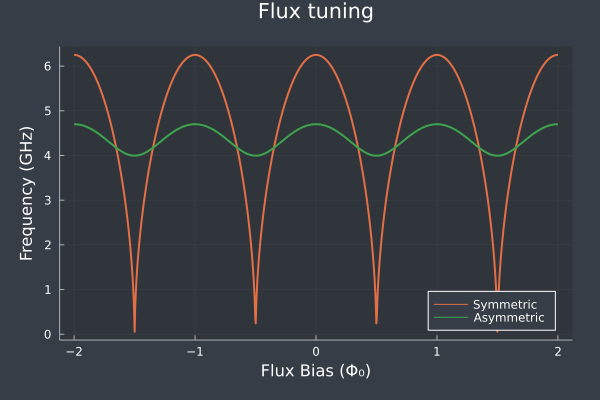

In [5]:
function transmon_frequency(ϕ, Ec, Ej₁, Ej₂)
    EjΣ = Ej₁ + Ej₂
    d = (Ej₂ - Ej₁) / EjΣ
    Ej = abs(EjΣ * cos(π * ϕ) * √(1 + d^2 * tan(π * ϕ)^2))
    return (√(8* Ec * Ej) - Ec)
end

Ec = 0.2 * GHz
Ej₁ = 13 * GHz
Ej₂ = 13 * GHz

transmon_frequency(ϕ) = transmon_frequency(ϕ, 0.2 * GHz, 13 * GHz, 13 * GHz)
ϕlist = range(-2,2,1000) |> collect
plot(title = "Flux tuning", xlabel = "Flux Bias (Φ₀)", ylabel = "Frequency (GHz)"; legend = :bottomright, plot_args...)
plot!(ϕlist, transmon_frequency.(ϕlist)/GHz, linewidth =2 , markersize = 0, label = "Symmetric", c = colors[2])

# symmetric transmon
transmon_frequency(ϕ) = transmon_frequency(ϕ, 0.2 * GHz, 13 * GHz, 2 * GHz)
plot!(ϕlist, transmon_frequency.(ϕlist)/GHz, linewidth =2 , markersize = 0, label = "Asymmetric", c = colors[3])

## iSwap gate via direct capacitive coupling

There are several way to build interactions between qubits. Here we will restrict to the case of capacitive coupling, which consists of placing a capacitance $C_g$ between two transmons, leading to the interaction Hamiltonian $H_{int} \propto C_g V_1V_2$, where $V_j = \frac{2e}{C_j}n_j$ and $C_j$ is the capacitance of transmon $j$. In the second quantization picture, the interaction Hamiltonian becomes 

$$ H_{int} \propto -g(a_1 - a_1^\dagger)(a_2 - a_2^\dagger)$$

which we will approximate as $H_{int}\approx g(a_1^\dagger a_2 + a_1a_2^\dagger)$ by neglectic the counter-rotating terms. The full Hamiltonian then becomes:

$$H = \sum_{j=1,2} \left[\omega_ja^\dagger_j a_j + \frac{\alpha_j}{2}a_j^\dagger a_j^\dagger a_j a_j \right] + g(a_1^\dagger a_2 + a_1a_2^\dagger)$$

Note that if we ignore the higher levels and truncate the Hamiltonian at the computational subspace, we recover the following spin Hamiltonian:

$$ H = \sum_{j=1,2}\frac{1}{2}\omega_j \sigma_j^z + g \sigma_1^y \sigma_2^y$$

#### A simple example: two-level transmons

We show now a simple example of a quantum gate realized via direct coupling of two transmons within a two-level system approximation. The Hamiltonian is simply the following:

In [6]:
function hamiltonian(ω⃗::Vector, g::Number)
    os = OpSum()
    
    os += ω⃗[q₁], "a† * a", q₁
    os += ω⃗[q₂], "a† * a", q₂
    
    os += g, "a†", q₁, "a", q₂
    os += g, "a", q₁, "a†", q₂
    
    return os
end

hamiltonian (generic function with 1 method)

In [7]:
# define the mode numbering
q₁, q₂ = 1, 2

# define the Hilbert space
hilbert = qudits(2; dim = 2)

2-element Vector{Index{Int64}}:
 (dim=2|id=357|"Qudit,Site,n=1")
 (dim=2|id=219|"Qudit,Site,n=2")

In [8]:
# define the system Hamiltonian
ω⃗ = [4 * GHz, 4 * GHz]
g = 10 * MHz
lazy_hamiltonian = hamiltonian(ω⃗, g)

sum(
  25.132741228718345 a† * a(1,)
  25.132741228718345 a† * a(2,)
  0.06283185307179587 a†(1,) a(2,)
  0.06283185307179587 a(1,) a†(2,)
)

In [9]:
H = MPO(lazy_hamiltonian, hilbert)

MPO
[1] ((dim=4|id=160|"Link,l=1"), (dim=2|id=357|"Qudit,Site,n=1")', (dim=2|id=357|"Qudit,Site,n=1"))
[2] ((dim=4|id=160|"Link,l=1"), (dim=2|id=219|"Qudit,Site,n=2")', (dim=2|id=219|"Qudit,Site,n=2"))


In [10]:
# initial state with an excitation on q₂, as a matrix product state
ψ₀₁ = productstate(hilbert, [0,1])

MPS
[1] ((dim=2|id=357|"Qudit,Site,n=1"),)
[2] ((dim=2|id=219|"Qudit,Site,n=2"),)


We will actually work with full states, since the system sizes we will consider are very small and we can avoid dealing with extra complexity introduced by matrix product states:

In [11]:
ψ₀₁ = prod(ψ₀₁)

ITensor ord=2 (dim=2|id=357|"Qudit,Site,n=1") (dim=2|id=219|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

The same thing applies to the Hamiltonian

In [12]:
H = prod(H)

ITensor ord=4 (dim=2|id=357|"Qudit,Site,n=1")' (dim=2|id=357|"Qudit,Site,n=1") (dim=2|id=219|"Qudit,Site,n=2")' (dim=2|id=219|"Qudit,Site,n=2")
NDTensors.Dense{Float64, Vector{Float64}}

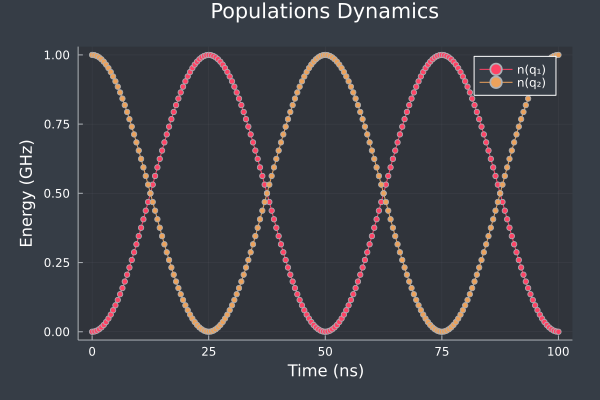

In [13]:
T  = 100.0     # final time
δt = 0.5       # time step
ts = 0.0:δt:T  # time schedule

populations = zeros(2, length(ts))
for (i,t) in enumerate(ts)
    Uₜ = exp(-im * H * t)
    ψₜ = noprime(Uₜ * ψ₀₁)
    populations[:, i] = expect(ψₜ, "n")
end

plot(title = "Populations Dynamics", xlabel = "Time (ns)", ylabel = "Energy (GHz)"; legend = :topright, plot_args...)
plot!(ts, populations[1,:] , label = "n(q₁)"; plot_args...)
plot!(ts, populations[2,:] , label = "n(q₂)"; plot_args...)

In [14]:
@printf("\nFull excitation swap at t = %.1fns\n\n", π/2g)

# let's compute the full unitary at t = π/2g
Ug = exp(-im * H * π/2g)
round.(PastaQ.array(Ug); digits=1)


Full excitation swap at t = 25.0ns



4×4 Matrix{ComplexF64}:
 1.0+0.0im   0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  -0.0+0.0im  0.0-1.0im  0.0+0.0im
 0.0+0.0im   0.0-1.0im  0.0-0.0im  0.0+0.0im
 0.0+0.0im   0.0+0.0im  0.0+0.0im  1.0+0.0im

### Effect of finite anharmonicity

In practice, the transmon is not a two-level system, and in fact, in some gate schemes the higher levels are use to implement the gate dynamics (e.g. the controlled-phased gate via tunable coupler). The Hamiltonian is identical as the one before, but we now introduce the anharmonicity.

In [15]:
function hamiltonian(ω⃗::Vector, α::Number, g::Number)
    os = OpSum()
    
    os += ω⃗[q₁], "a† * a", q₁
    os += ω⃗[q₂], "a† * a", q₂
    
    os += α/2, "a† * a† * a * a", q₁
    os += α/2, "a† * a† * a * a", q₂
    
    os += g, "a†", q₁, "a", q₂
    os += g, "a", q₁, "a†", q₂
    
    return os
end

hamiltonian (generic function with 2 methods)

We once again define the Hilbert space, and keep the first 3 levels of each transmon:

In [16]:
q₁, q₂ = 1, 2
hilbert = qudits(2; dim = 3)

ω⃗ = [4 * GHz, 4 * GHz]
g = 10 * MHz

α = -200 * MHz

-1.2566370614359172

We can compute what is the process fidelity between the perfect iSwap gate, and the unitary matrix corresponding to the dynamics generated by this Hamiltonian at time $t = \pi/2g$. Instead of building the full process matrix, we compute the process fidelity by averaging the inner product of the relevant states in the Hilbert space (making sure to take the absolute values afterwards):

In [17]:
ideal_gate = [
  [0,0] => (1,   [0,0]),
  [1,0] => (-im, [0,1]),
  [0,1] => (-im, [1,0]),
  [1,1] => (1,   [1,1])
]

ψ⃗₀ = prod.([productstate(hilbert, σ) for σ in first.(ideal_gate)])
ψ⃗iswap  = prod.([phase * productstate(hilbert, σ) for (phase, σ) in last.(ideal_gate)]);

In [18]:
t = π / 2g

lazy_hamiltonian = hamiltonian(ω⃗, α, g)
H = prod(MPO(lazy_hamiltonian, hilbert))

Uₜ = exp(-im * H * t)
ψ⃗ₜ = [noprime(Uₜ * ψ₀) for ψ₀ in ψ⃗₀]
gate_infidelity = 1 - abs2(mean([inner(ψₜ, ψiswap) for (ψₜ,ψiswap) in zip(ψ⃗ₜ, ψ⃗iswap)]))

0.018223763889700817

So not a perfect iSwap eh! Let's scale the infidelity with the anharmonicity. We can see that as $\alpha$ grows large, the gate infidelity decreases towards zero, since in that limit we recover a perfect qubit (tho this would be unrealistic since there is a practical limit to how large the anharmonicity can get, since it is negative).

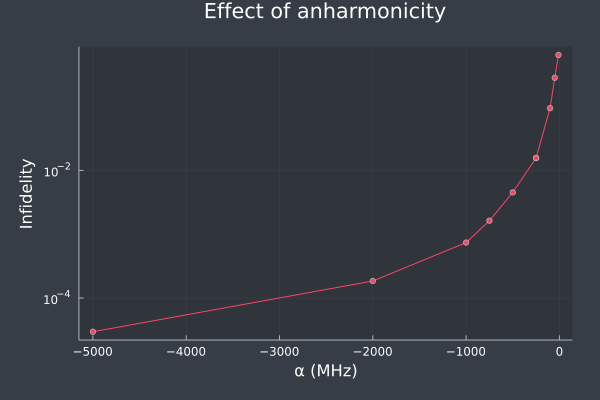

In [19]:
α_sweep = -[10,50,100,250, 250, 500, 750, 1000, 2000, 5000] * MHz
infidelity_sweep = []
for α in α_sweep
    lazy_hamiltonian = hamiltonian(ω⃗, α, g)
    H = prod(MPO(lazy_hamiltonian, hilbert))
    
    Uₜ = exp(-im * H * t)
    ψ⃗ₜ = [noprime(Uₜ * ψ₀) for ψ₀ in ψ⃗₀]
    push!(infidelity_sweep, 1 - abs2(mean([inner(ψₜ, ψiswap) for (ψₜ,ψiswap) in zip(ψ⃗ₜ, ψ⃗iswap)])))
end

plot(title = "Effect of anharmonicity", xlabel = "α (MHz)", ylabel = "Infidelity"; legend = false, plot_args...)
plot!(α_sweep/MHz, infidelity_sweep; yscale = :log10, plot_args...)

One may wonder why exactly the fidelity decreases when considering a transmons instead of a qubit. The reason is leakage, that is driving the transmon state out of the computational subspace. Let's measure that more concretely. Let's initialize the transmon in the $|11\rangle$ state, and time-evolve it with the above Hamiltonian. For this system, the leakage channels involves the bring state $|\psi_{bright}\rangle=(|20\rangle +|02\rangle)/\sqrt{2}$:

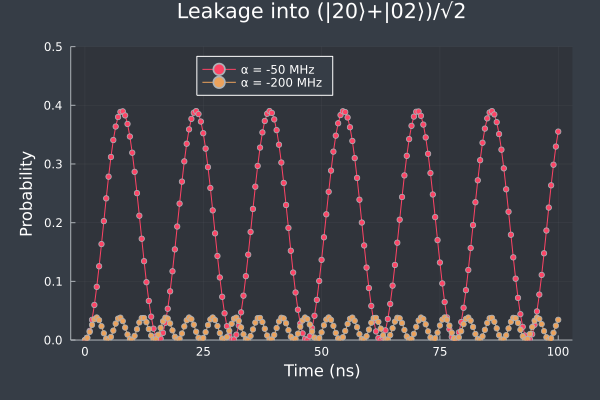

In [20]:
# let's keep track of the probabiliy to leak into the bring state.
leakage_probability_α50 = [] 
leakage_probability_α200 = [] 

# initial state
ψ₁₁ = prod(productstate(hilbert,[1,1]))

# leakage channel
ψbright = (prod(productstate(hilbert,[2,0])) + prod(productstate(hilbert,[0,2])))/√2 

# Hamiltonian with small anharmonicity α = -50 MHz
lazy_hamiltonian = hamiltonian(ω⃗, -50 * MHz, g)
H_α50 = prod(MPO(lazy_hamiltonian, hilbert))

# Hamiltonian with small anharmonicity α = -200 MHz
lazy_hamiltonian = hamiltonian(ω⃗, -200 * MHz, g)
H_α200 = prod(MPO(lazy_hamiltonian, hilbert))

# time sweep
for (i,t) in enumerate(ts)
    ψₜ = noprime(exp(-im * H_α50 * t) * ψ₁₁)
    push!(leakage_probability_α50, abs2(inner(ψbright,ψₜ)))
    
    ψₜ = noprime(exp(-im * H_α200 * t) * ψ₁₁)
    push!(leakage_probability_α200, abs2(inner(ψbright,ψₜ)))
end

p = plot(title = "Leakage into (|20⟩+|02⟩)/√2", xlabel = "Time (ns)", ylabel = "Probability"; legend = :top, plot_args...)
p = plot!(p, ts, leakage_probability_α50 , label = "α = -50 MHz"; yrange =[0,0.5],plot_args...)
p = plot!(p, ts, leakage_probability_α200 , label = "α = -200 MHz"; yrange =[0,0.5],plot_args...)
p

## Tunable couplers

<img src="coupler.jpg" width=50% height=50%>

Image from: https://arxiv.org/abs/1803.09813

In [21]:
q₁, c, q₂ = 1,2,3
hilbert = qudits(3; dim = 3)

3-element Vector{Index{Int64}}:
 (dim=3|id=351|"Qudit,Site,n=1")
 (dim=3|id=942|"Qudit,Site,n=2")
 (dim=3|id=797|"Qudit,Site,n=3")

In [22]:
# anharmonicity
α⃗ =[-220 * MHz, -90 * MHz, -210 * MHz]

# fixed-frequency qubit
ωq₁ = 4.16 * GHz

# circuit capacitances
C₁ = 95 * fF
Cc = 228 * fF
C₂ = 98 * fF
C₁c = 5.36 * fF
C₂c = 5.36 * fF
C₁₂ = 0.125 * fF

qubit_coupler_interaction(ωq, ωc, Cqc, Cq) = 0.5 * Cqc / √(Cq * Cc) * √(ωq * ωc)

q₁c_interaction(ωq, ωc) = qubit_coupler_interaction(ωq, ωc, C₁c, C₁)
q₂c_interaction(ωq, ωc) = qubit_coupler_interaction(ωq, ωc, C₂c, C₂)

function q₁q₂_interaction(ωq₁, ωq₂)
    η = C₁c * C₂c / (C₁₂ * Cc)
    return 0.5 * (1 + η) * C₁₂ / √(C₁ * C₂) * √(ωq₁ * ωq₂)     
end

ω⃗ = [4.16 * GHz, 4.16 * GHz, 4.16 * GHz]
@printf("Couplings at resonant frequency ω = 4.16 GHz\n")
@printf(" - Q₁-C = %.4f MHz\n", q₁c_interaction(ω⃗[q₁], ω⃗[c]) / MHz)
@printf(" - Q₂-C = %.4f MHz\n", q₂c_interaction(ω⃗[q₂], ω⃗[c]) / MHz)
@printf(" - Q₁-Q₂ = %.4f MHz\n", q₁q₂_interaction(ω⃗[q₁], ω⃗[q₂]) / MHz)

Couplings at resonant frequency ω = 4.16 GHz
 - Q₁-C = 75.7528 MHz
 - Q₂-C = 74.5843 MHz
 - Q₁-Q₂ = 5.4110 MHz


In [23]:
function hamiltonian(ω⃗::Vector, α⃗::Vector)

    # compute the frequency-dependent couplings
    g₁c = q₁c_interaction(ω⃗[q₁], ω⃗[c])
    g₂c = q₂c_interaction(ω⃗[q₂], ω⃗[c])
    g₁₂ = q₁q₂_interaction(ω⃗[q₁], ω⃗[q₂])
    
    os = OpSum()
    
    # on-site energy
    os += ω⃗[q₁], "a† * a", q₁
    os += ω⃗[c], "a† * a", c
    os += ω⃗[q₂], "a† * a", q₂
    
    # anharmonicity
    os += α⃗[q₁]/2, "a† * a† * a * a", q₁
    os += α⃗[c]/2, "a† * a† * a * a", c
    os += α⃗[q₂]/2, "a† * a† * a * a", q₂
    
    # exchange interaction
    os += g₁c, "a†", q₁, "a", c
    os += g₁c, "a", q₁, "a†", c
    
    os += g₂c, "a†", q₂, "a", c
    os += g₂c, "a", q₂, "a†", c
    
    os += g₁₂, "a†", q₁, "a", q₂
    os += g₁₂, "a", q₁, "a†", q₂

    return os
end

hamiltonian (generic function with 3 methods)

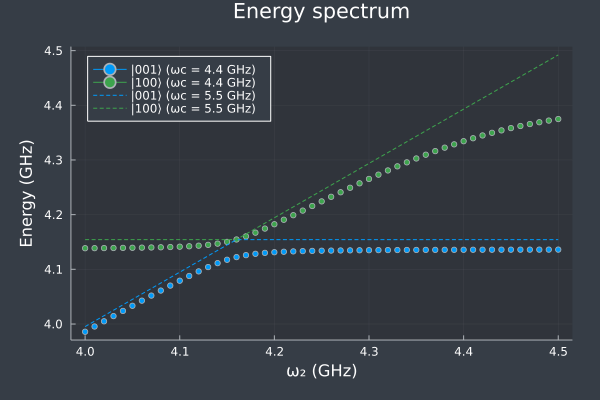

In [24]:
ωq₂_sweep  = (4.0:0.01:4.5) * GHz

ωc = 5.5 * GHz
λ⃗ = zeros(27, length(ωq₂_sweep))
for (i,ωq₂) in enumerate(ωq₂_sweep)
    ω⃗ = [ωq₁, ωc, ωq₂]
    lazy_hamiltonian = hamiltonian(ω⃗, α⃗)
    H = prod(MPO(lazy_hamiltonian, hilbert))
    D, U = eigen(H)
    λ⃗[:,i] = diag(PastaQ.array(D))
end
E₀₀₁_off = λ⃗[2,:]
E₁₀₀_off = λ⃗[3,:]

ωc = 4.4 * GHz
λ⃗ = zeros(27, length(ωq₂_sweep))
for (i,ωq₂) in enumerate(ωq₂_sweep)
    ω⃗ = [ωq₁, ωc, ωq₂]
    lazy_hamiltonian = hamiltonian(ω⃗, α⃗)
    H = prod(MPO(lazy_hamiltonian, hilbert))
    D, U = eigen(H)
    λ⃗[:,i] = diag(PastaQ.array(D))
end
E₀₀₁_on = λ⃗[2,:]
E₁₀₀_on = λ⃗[3,:]

plot(title = "Energy spectrum", xlabel = "ω₂ (GHz)", ylabel = "Energy (GHz)"; legend = :topleft, plot_args...)
plot!(ωq₂_sweep/GHz, E₀₀₁_on/GHz, marker = :circle, markersize = 3, linewidth = 0, label = "|001⟩ (ωc = 4.4 GHz) ", color = colors[1])
plot!(ωq₂_sweep/GHz, E₁₀₀_on/GHz, marker = :circle, markersize = 3, linewidth = 0, label = "|100⟩ (ωc = 4.4 GHz) ", color = colors[3])

plot!(ωq₂_sweep/GHz, E₀₀₁_off/GHz, markersize = 0, linestyle = :dash, label = "|001⟩ (ωc = 5.5 GHz)", color = colors[1])
plot!(ωq₂_sweep/GHz, E₁₀₀_off/GHz, markersize = 0, linestyle = :dash, label = "|100⟩ (ωc = 5.5 GHz)", color = colors[3])

We can obtain an explicit expression for the effective couplings between the qubits by applying a Schrieffer-Wolf transformation to the Hamiltonian, specific by the unitary operator

$$ U = \exp\left(\sum_{j=1,2}\left[\frac{g_j}{\omega_j-\omega_c}\left(a_j^\dagger a_c - a_ja_c^\dagger\right) - \frac{g_j}{\omega_j+\omega_c}\right]\left(a_j^\dagger a_c^\dagger - a_ja_c\right) \right)$$

which decouples the Hamiltonian as $\tilde{H} = UHU^\dagger = \tilde{H}_0 +\tilde{g}\left(b_1^\dagger b_2 + b_1b_2^\dagger\right)$, where the effective qubit-qubit coupling is:

In [25]:
function effecive_qubit_interaction(ω⃗)
    η = C₁c * C₂c / (C₁₂ * Cc)
    Σ₁ = ω⃗[q₁] + ω⃗[c]
    Σ₂ = ω⃗[q₂] + ω⃗[c]
    Δ₁ = ω⃗[q₁] - ω⃗[c]
    Δ₂ = ω⃗[q₂] - ω⃗[c]
    return 0.5 * (0.25*ω⃗[c]*η*(1/Δ₁ + 1/Δ₂ - 1/Σ₁ - 1/Σ₂) + η + 1) *  C₁₂ / √(C₁ * C₂) * √(ω⃗[q₁] * ω⃗[q₂])
end

effecive_qubit_interaction (generic function with 1 method)

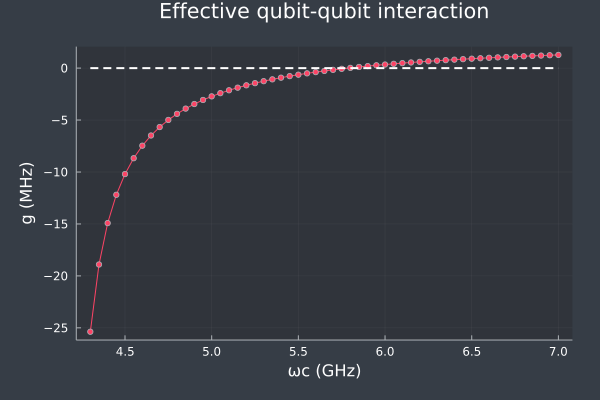

In [26]:
ωq₂ = 4.00 * GHz
ωclist  = (4.3:0.05:7) * GHz
ω⃗list = [[ωq₁, ωc, ωq₂] for ωc in ωclist]
g_scan = effecive_qubit_interaction.(ω⃗list)
ωc_critical = ωclist[argmin(g_scan .^ 2)]
plot(title = "Effective qubit-qubit interaction", xlabel = "ωc (GHz)", ylabel = "g (MHz)"; legend = false, plot_args...)
plot!(ωclist / GHz, g_scan / MHz;  plot_args...)
plot!([ωclist[1]; ωclist[end]]./GHz, [0; 0], lw=2, lc=:white, legend=false, linestyle = :dash)

### Parasitic ZZ interactions

In [27]:
bare_basis = [
    "000" => productstate(hilbert, [0,0,0]),
    "100" => productstate(hilbert, [1,0,0]),
    "001" => productstate(hilbert, [0,0,1]),
    "101" => productstate(hilbert, [1,0,1]),
]
bare_basis = Dict(bare_basis);

In [28]:
function dressed_solver(hamiltonian::OpSum, hilbert::Vector{<:Index})
    H = prod(MPO(hamiltonian, hilbert))
    D, U = eigen(H)
    λ = diag(PastaQ.array(D))
    
    ϕ = array(U)
    ϕ = reshape(ϕ,(prod(dims(hilbert)), prod(dims(hilbert))))
    ϕ = [col for col in eachcol(ϕ)]
    
    dressed_eigenstates_idxs = []
    for ψ₀ in values(bare_basis)
        overlaps = []
        for (j,ϕⱼ) in enumerate(ϕ)
            push!(overlaps, abs2(ϕⱼ' * PastaQ.array(ψ₀)))
        end
        push!(dressed_eigenstates_idxs, argmax(overlaps))
    end
    return Dict(keys(bare_basis) .=> λ[dressed_eigenstates_idxs])
end

dressed_solver (generic function with 1 method)

In [29]:
ωq₂_sweep  = (3.6:0.005:4.6) * GHz
ωc_sweep  = (4.8:0.005:6) * GHz
ωq₁ = 4.16 * GHz

zz_data = zeros(length(ωc_sweep), length(ωq₂_sweep))
@showprogress for (i,ωc) in enumerate(ωc_sweep)
    for (j,ωq₂) in enumerate(ωq₂_sweep)
        ω⃗ = [ωq₁, ωc, ωq₂]
        lazy_hamiltonian = hamiltonian(ω⃗, α⃗)
        λmap = dressed_solver(lazy_hamiltonian, hilbert)
        zz_data[i,j] = abs(λmap["101"] + λmap["000"] - λmap["100"] - λmap["001"])/MHz
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:54


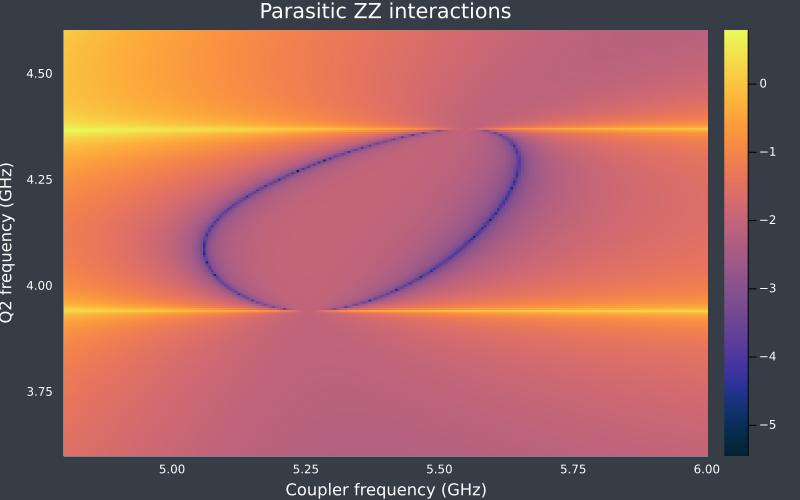

In [30]:
heatmap(ωc_sweep/GHz, ωq₂_sweep/GHz, log10.(zz_data'), c = :thermal, title = "Parasitic ZZ interactions",
    xlabel = "Coupler frequency (GHz)", ylabel = "Q2 frequency (GHz)", size = (800, 500))

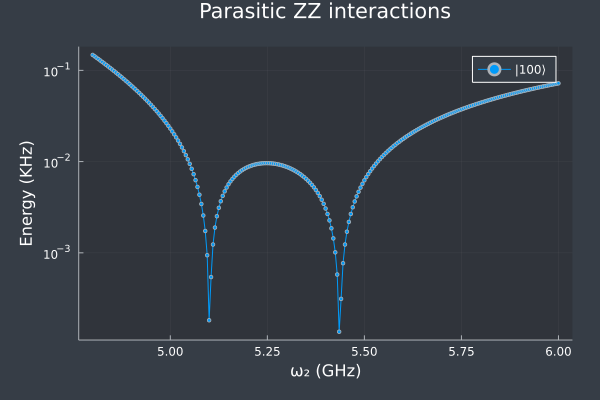

In [31]:
ωq₂ = 4.00 * GHz
ω2idx = findfirst(x -> x ≈ ωq₂, ωq₂_sweep)
zz_data_slice = zz_data[:,ω2idx]

plot(title = "Parasitic ZZ interactions", xlabel = "ω₂ (GHz)", ylabel = "Energy (KHz)"; plot_args...)
plot!(ωc_sweep/GHz, zz_data_slice, marker = :circle, markersize = 2, yscale = :log10,  label = "|100⟩", c = colors[1])

We can pick one of the two low-ZZ points for the idle spot of the coupler:

In [33]:
dips = findpeaks(-zz_data_slice)
ωc_idle = ωc_sweep[dips[1]]

ω⃗_idle = [ωq₁, ωc_idle, ωq₂]
ω⃗_idle / GHz

3-element Vector{Float64}:
 4.16
 5.435
 4.0

We can simply look at the accumulated ZZ phase during the dynamics:

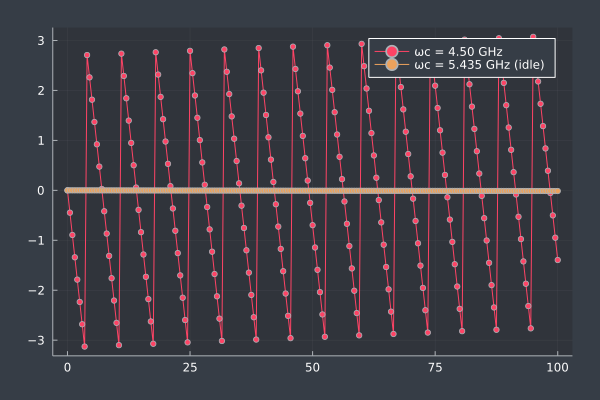

In [47]:
tlist = 0.0:5:2300

ωc  = 4.5 * GHz
ω⃗ = [ω⃗_idle[q₁], ωc, ω⃗_idle[q₂]]
lazy_hamiltonian = hamiltonian(ω⃗, α⃗)
H = prod(MPO(lazy_hamiltonian, hilbert))
λmap = dressed_solver(lazy_hamiltonian, hilbert)
ζ = abs(λmap["101"] + λmap["000"] - λmap["100"] - λmap["001"])/MHz

ωc = ωc_idle
ω⃗ = [ω⃗_idle[q₁], ωc, ω⃗_idle[q₂]]
lazy_hamiltonian = hamiltonian(ω⃗, α⃗)
H_idle = prod(MPO(lazy_hamiltonian, hilbert))
λmap = dressed_solver(lazy_hamiltonian, hilbert)
ζ_idle = abs(λmap["101"] + λmap["000"] - λmap["100"] - λmap["001"])/MHz

ζt = angle.(exp.(-im * ts * ζ))
ζt_idle = angle.(exp.(-im * ts * ζ_idle))

plot(title = "Accumulated conditional ZZ phase", xlabel = "time (μs)", ylabel = "ϕzz", legend = :topright; plot_args...)
plot(ts, ζt; label = "ωc = 4.50 GHz", plot_args...)
plot!(ts, ζt_idle; label = "ωc = $(round(ωc_idle/GHz, digits = 3)) GHz (idle)", plot_args...)

Cross-Ramsey type experiment:

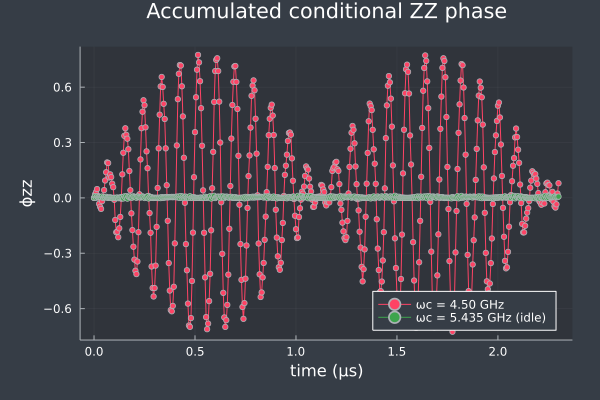

In [48]:
ψα = prod(productstate(hilbert, [0,0,0]) + productstate(hilbert, [0,0,1]))/√2
ψβ = prod(productstate(hilbert, [1,0,0]) + productstate(hilbert, [1,0,1]))/√2

cphase = []
cphase_idle = []
for (it, t) in enumerate(tlist)
    Uₜ = exp(-im * H * t)
    ϕα = noprime(Uₜ * ψα)
    ϕβ = noprime(Uₜ * ψβ)
    push!(cphase, atan(abs2(inner(ψα, ϕα))) - atan(abs2(inner(ψβ, ϕβ))))
    
    Uₜ = exp(-im * H_idle * t)
    ϕα = noprime(Uₜ * ψα)
    ϕβ = noprime(Uₜ * ψβ)
    push!(cphase_idle, atan(abs2(inner(ψα, ϕα))) - atan(abs2(inner(ψβ, ϕβ))))
end

plot(title = "Accumulated conditional ZZ phase", xlabel = "time (μs)", ylabel = "ϕzz"; legend = :bottomright, plot_args...)
plot!(tlist/1e3, cphase; label = "ωc = 4.50 GHz", plot_args...)
plot!(tlist/1e3, cphase_idle;  label = "ωc = $(round(ωc_idle/GHz, digits = 3)) GHz (idle)", color = colors[3], plot_args...)

## Building the gate

In [49]:
ideal_gate = [
  [0,0,0] => (1,   [0,0,0]),
  [1,0,0] => (-im, [0,0,1]),
  [0,0,1] => (-im, [1,0,0]),
  [1,0,1] => (1,   [1,0,1])
]

ψ⃗₀ = prod.([productstate(hilbert, σ) for σ in first.(ideal_gate)])
ψ⃗iswap  = prod.([phase * productstate(hilbert, σ) for (phase, σ) in last.(ideal_gate)]);

In [50]:
ωc_sweep = (4.2:0.001:7) .* GHz
tlist = 0.0:1:400

population_transfer_probability = zeros(length(tlist), length(ωc_sweep))

ψ₀₀₁ = prod(productstate(hilbert, [0,0,1]))
ψ₁₀₀ = prod(productstate(hilbert, [1,0,0]))

ωq₁ = 4.16 * GHz
ωq₂ = 4.16 * GHz

@showprogress for (iω,ωc) in enumerate(ωc_sweep)
    ω⃗ = [ωq₁, ωc, ωq₂]
    lazy_hamiltonian = hamiltonian(ω⃗, α⃗)
    H = prod(MPO(lazy_hamiltonian, hilbert))
    
    for (it, t) in enumerate(tlist)
        Uₜ = exp(-im * H * t)
        ψₜ = noprime(Uₜ * ψ₀₀₁)
        population_transfer_probability[it, iω] = abs2(inner(ψ₁₀₀, ψₜ))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:13:06


In [53]:
heatmap(ωc_sweep/GHz, tlist, population_transfer_probability, c = :thermal, title = "Population transfer",
    xlabel = "Coupler frequency (GHz)", ylabel = "time (ns)", size = (800, 500))

ωc_gate / GHz = 4.576
population_transfer_probability[t_idx, ωc_idx] = 0.9933658075519128


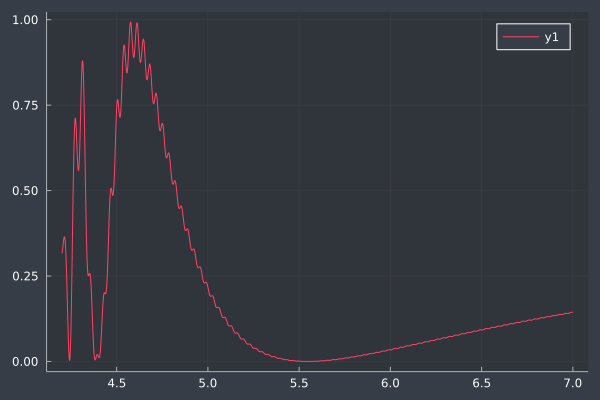

In [104]:
t_gate = 30
t_idx = findfirst(x -> x ≈ t_gate, tlist)
ωc_idx = argmax(population_transfer_probability[t_idx, :])
ωc_gate = ωc_sweep[ωc_idx]
@show ωc_gate/GHz
@show population_transfer_probability[t_idx, ωc_idx]
plot(ωc_sweep/GHz, population_transfer_probability[t_idx, :])

In [105]:
function tanh_pulse(t, t₀, ton, toff, y0, y1, γ)
    if t < ton || t > toff 
        return y0
    end
    return y0 + 0.5 * (y1 - y0) * (tanh((t - ton)/γ) - tanh((t - toff)/γ))
end

tanh_pulse (generic function with 1 method)

In [106]:
function hamiltonian(ω⃗::Vector, α⃗::Vector, t::Number)

    ωq₁ = ω⃗[q₁]
    ωq₂ = ω⃗[q₂](t)
    ωc  = ω⃗[c](t)

    g₁c = q₁c_interaction(ωq₁, ωc)
    g₂c = q₂c_interaction(ωq₂, ωc)
    g₁₂ = q₁q₂_interaction(ωq₁, ωq₂)
    
    os = OpSum()
    
    os += ωq₁, "a† * a", q₁
    os += ωc, "a† * a", c
    os += ωq₂, "a† * a", q₂
    
    os += α⃗[q₁]/2, "a† * a† * a * a", q₁
    os += α⃗[c]/2, "a† * a† * a * a", c
    os += α⃗[q₂]/2, "a† * a† * a * a", q₂
    
    os += g₁c, "a†", q₁, "a", c
    os += g₁c, "a", q₁, "a†", c
    
    os += g₂c, "a†", q₂, "a", c
    os += g₂c, "a", q₂, "a†", c
    
    os += g₁₂, "a†", q₁, "a", q₂
    os += g₁₂, "a", q₁, "a†", q₂

    return os
end

hamiltonian (generic function with 4 methods)

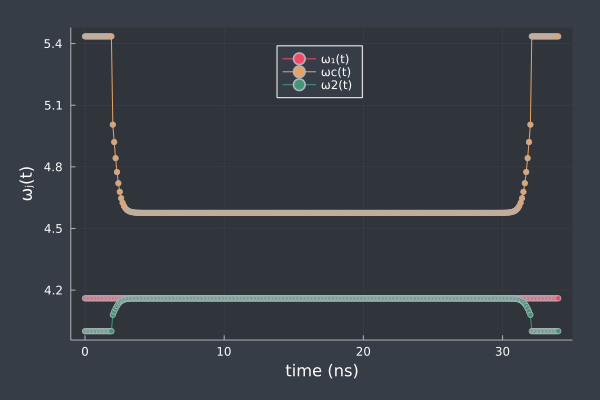

In [110]:
ωq₁ = 4.16 * GHz
ωq₂ = 4.00 * GHz
ωc  = ωc_idle
ω⃗₀ = [ωq₁, ωc, ωq₂]

Tg = t_gate
t_offset = 2
t₀ = 0.0
ton = t₀ + t_offset
toff = ton + Tg
T = toff + t_offset

γ = 0.5

δt = 0.1
ts = collect(t₀:δt:T)

pulse_c(t) = tanh_pulse(t, t₀, ton, toff, ω⃗₀[c], ωc_gate, γ) 
pulse_q₂(t) = tanh_pulse(t, t₀, ton, toff, ω⃗₀[q₂], ωq₁, γ) 

ωc_pulse = [pulse_c(t) for t in ts]
ωq₂_pulse = [pulse_q₂(t) for t in ts]

p = plot(xlabel = "time (ns)", ylabel = "ωⱼ(t)", title = "", legend = (0.50,0.9); plot_args...)
p = plot!(p, ts, repeat([ω⃗₀[q₁]], length(ts)) ./ GHz; label = "ω₁(t)", plot_args...)
p = plot!(p, ts, ωc_pulse ./ GHz; label = "ωc(t)", plot_args...)
p = plot!(p, ts, ωq₂_pulse ./ GHz; label = "ω2(t)", plot_args...)

### Pulse optimization

In [112]:
function infidelity(Θ)
    ωc_pulse, ϕ₁, ϕ₂ = Θ
    
    pulse_c(t) = tanh_pulse(t, t₀, ton, toff, ω⃗₀[c], ωc_pulse, γ)
    
    inner_products = bufferfrom([[] for _ in 1:nthreads])
    @sync begin
    for t in 1:nthreads
        Threads.@spawn begin
            ip = Complex[]
            tset = threadsset[t]
            for k in tset
                ψ = copy(ψ⃗₀[k])
                for t in ts
                    lazy_hamiltonian = hamiltonian([ωq₁, pulse_c, pulse_q₂], α⃗, t)
                    H = prod(MPO(lazy_hamiltonian, hilbert))
                    Ut = exp(-im * H * δt)
                    ψ = noprime(Ut * ψ)
                end
                Z_rotation = op("Rz", hilbert[q₁]; ϕ = ϕ₁) * op("Rz", hilbert[q₂]; ϕ = ϕ₂)
                ψ = noprime(Z_rotation * ψ)
                ip = vcat(ip, inner(ψ⃗iswap[k], ψ))
            end
            inner_products[t] = ip
        end
    end
    end
    return 1 - abs2(mean(mean(inner_products)))
end

infidelity (generic function with 1 method)

In [113]:
ϵ = 1e-8
function loss_n_grad(f, Θ)
  ∇ = []
  f₀ = f(Θ)
  for j in 1:length(Θ)
    Θ[j] += ϵ
    fϵ = f(Θ)
    Θ[j] -= ϵ
    push!(∇, (fϵ - f₀)/ϵ)
  end
  return f₀, ∇
end

loss_n_grad (generic function with 2 methods)

In [115]:
Random.seed!(12345)
Θ₀ = [ωc_gate, π * rand(2)...]
@show infidelity(Θ₀)

loss_n_grad(x) = loss_n_grad(infidelity, x)
optimizer = OptimKit.LBFGS(verbosity = 2, maxiter = 10, gradtol = 1e-5)
Θ, fs, gs, niter, normgradhistory = OptimKit.optimize(loss_n_grad, Θ₀, optimizer)

infidelity(Θ₀) = 0.021551574990689493


┌ Info: LBFGS: initializing with f = 0.021551574991, ‖∇f‖ = 1.6843e-01
└ @ OptimKit /Users/gttorlai/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:35
┌ Info: LBFGS: iter    1: f = 0.018732276926, ‖∇f‖ = 1.6213e-01, α = 3.38e-02, m = 0, nfg = 6
└ @ OptimKit /Users/gttorlai/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    2: f = 0.005604621876, ‖∇f‖ = 7.3828e-02, α = 1.03e+01, m = 1, nfg = 4
└ @ OptimKit /Users/gttorlai/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    3: f = 0.005307038529, ‖∇f‖ = 4.9228e-03, α = 1.00e+00, m = 2, nfg = 1
└ @ OptimKit /Users/gttorlai/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    4: f = 0.005305073706, ‖∇f‖ = 3.9781e-03, α = 1.00e+00, m = 3, nfg = 1
└ @ OptimKit /Users/gttorlai/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    5: f = 0.005294854600, ‖∇f‖ = 4.5066e-03, α = 1.00e+00, m = 4, nfg = 1
└ @ OptimKit /Users/gttorlai/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ I

([28.776050984997426, 2.712892824089421, 2.712879361311379], 0.0052902893799301465, Any[1.454392162258955e-6, 8.43769498715119e-7, -5.873079800267078e-6], 17, [0.021551574990689493 0.16843088700101644; 0.018732276926376024 0.1621300864292895; … ; 0.005290293056535056 0.0002540912506821352; 0.0052902893799301465 6.109031827459031e-6])

### Population dynamics

minimum(IF) = 0.10609698357113728
ts[argmin(IF)] = 33.6


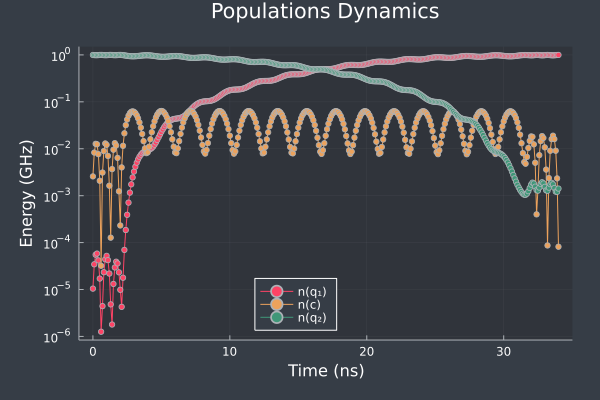

In [116]:
pulse_c(t) = tanh_pulse(t, t₀, ton, toff, ω⃗₀[c], Θ[1], γ) 

ψ⃗ = copy.(ψ⃗₀)
IF = []
populations = zeros(3,length(ts))
for (i,t) in enumerate(ts)
    lazy_hamiltonian = hamiltonian([ωq₁, pulse_c, pulse_q₂], α⃗, t)
    H = prod(MPO(lazy_hamiltonian, hilbert))
    Ut = exp(-im * H * δt)
    ψ⃗ = [noprime(Ut * ψ) for ψ in ψ⃗]
    push!(IF, 1 - abs2(mean([inner(ϕ,ψ) for (ϕ,ψ) in zip(ψ⃗iswap, ψ⃗)])))
    populations[:, i] = expect(ψ⃗[3], "n")
end
@show minimum(IF)
@show ts[argmin(IF)]
plot(title = "Populations Dynamics", xlabel = "Time (ns)", ylabel = "Energy (GHz)"; legend = :bottom, plot_args...)
plot!(ts, populations[1,:] , label = "n(q₁)"; plot_args...)
plot!(ts, populations[2,:] , label = "n(c)"; plot_args...)
plot!(ts, populations[3,:] , label = "n(q₂)"; yscale = :log10, plot_args...)

### Leakage

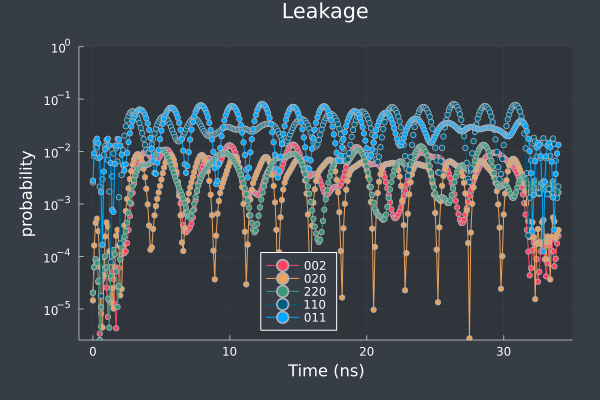

In [117]:
IF = []
leakage_labels = ["002","020","220","110","011"]
ψ_leakage = [
    prod(productstate(hilbert,[0,0,2])),
    prod(productstate(hilbert,[0,2,0])),
    prod(productstate(hilbert,[2,0,0])),
    prod(productstate(hilbert,[1,1,0])),
    prod(productstate(hilbert,[0,1,1]))
]
                    
leakage_probabilities = zeros(length(leakage_labels), length(ts))
ψ = prod(productstate(hilbert,[1,0,1]))

for (i,t) in enumerate(ts)
    lazy_hamiltonian = hamiltonian([ωq₁, pulse_c, pulse_q₂], α⃗, t)
    H = prod(MPO(lazy_hamiltonian, hilbert))
    Uₜ = exp(-im * H * δt)
    ψ = noprime(Uₜ * ψ)
    for (j,ψⱼ) in enumerate(ψ_leakage)
        leakage_probabilities[j,i] = abs2(inner(ψⱼ,ψ))
    end
end
p = plot(title = "Leakage", xlabel = "Time (ns)", ylabel = "probability"; legend = :bottom, plot_args...)
for (l, leakage_label) in enumerate(leakage_labels)
    p = plot!(p, ts, leakage_probabilities[l,:] , label = leakage_label; yticks = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1], yrange = [minimum(leakage_probabilities), 1], yscale = :log10, plot_args...)
end
p

## Extras

### Crosstalk

In [118]:
q₁, c₁, q₂, c₂, q₃ = 1,2,3,4,5
hilbert = qudits(5; dim = 3)

α⃗ =[-220 * MHz, -90 * MHz, -210 * MHz, -90 * MHz,-220 * MHz]

g_q₁c₁ = 75 * MHz
g_c₁q₂ = 75 * MHz
g_q₂c₂ = 75 * MHz
g_c₂q₃ = 75 * MHz

g_q₁q₂ = 5 * MHz
g_q₂q₃ = 5 * MHz

0.031415926535897934

In [119]:
function hamiltonian(ω⃗::Vector, α⃗::Vector, t::Number)
    ωq₁ = ω⃗[q₁]
    ωc₁ = ω⃗[c₁]  isa Function ? ω⃗[c₁](t)  : ω⃗[c₁]
    ωq₂ = ω⃗[q₂] isa Function ? ω⃗[q₂](t) : ω⃗[q₂]
    ωc₂ = ω⃗[c₂]
    ωq₃ = ω⃗[q₃]
    
    g_q₁c₁ = q₁c_interaction(ωq₁, ωc₁)
    g_c₁q₂ = q₁c_interaction(ωq₂, ωc₁)
    g_q₂c₂ = q₁c_interaction(ωq₂, ωc₂)
    g_c₂q₃ = q₁c_interaction(ωq₃, ωc₂)
    
    g_q₁q₂ = q₁q₂_interaction(ωq₁, ωq₂)
    g_q₂q₃ = q₁q₂_interaction(ωq₂, ωq₃)
    
    H = Tuple[]
    H = vcat(H, [(ωq₁, "a† * a", q₁)])
    H = vcat(H, [(ωc₁, "a† * a", c₁)])
    H = vcat(H, [(ωq₂, "a† * a", q₂)])
    H = vcat(H, [(ωc₂, "a† * a", c₂)])
    H = vcat(H, [(ωq₃, "a† * a", q₃)])
    
    H = vcat(H, [(α⃗[q₁]/2, "a† * a† * a * a", q₁)])
    H = vcat(H, [(α⃗[c₁]/2, "a† * a† * a * a", c₁)])
    H = vcat(H, [(α⃗[q₂]/2, "a† * a† * a * a", q₂)])
    H = vcat(H, [(α⃗[c₂]/2, "a† * a† * a * a", c₂)])
    H = vcat(H, [(α⃗[q₃]/2, "a† * a† * a * a", q₃)])
    
    H = vcat(H, [(g_q₁c₁, "a†b", (q₁, c₁))])
    H = vcat(H, [(g_q₁c₁, "ab†", (q₁, c₁))])
    
    H = vcat(H, [(g_c₁q₂, "a†b", (c₁, q₂))])
    H = vcat(H, [(g_c₁q₂, "ab†", (c₁, q₂))])
    
    H = vcat(H, [(g_q₂c₂, "a†b", (q₂, c₂))])
    H = vcat(H, [(g_q₂c₂, "ab†", (q₂, c₂))])
    
    H = vcat(H, [(g_c₂q₃, "a†b", (c₂, q₃))])
    H = vcat(H, [(g_c₂q₃, "ab†", (c₂, q₃))])
    
    H = vcat(H, [(g_q₁q₂, "a†b", (q₁, q₂))])
    H = vcat(H, [(g_q₁q₂, "ab†", (q₁, q₂))])

    H = vcat(H, [(g_q₂q₃, "a†b", (q₂, q₃))])
    H = vcat(H, [(g_q₂q₃, "ab†", (q₂, q₃))])
    
end

hamiltonian (generic function with 4 methods)

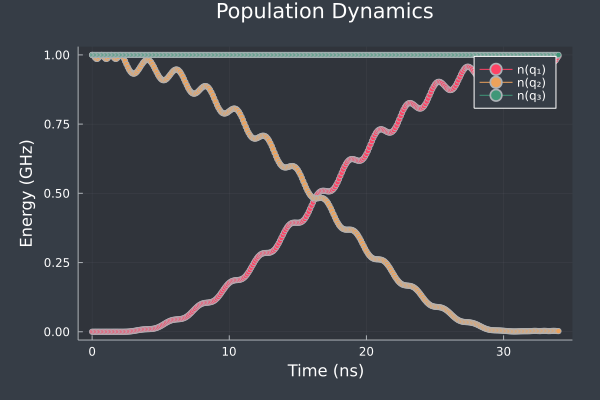

In [120]:
ωq₁ = 4.16 * GHz
ωc₁ = ωc_gate
ωq₂ = 4.16 * GHz
ωc₂ = 0
ωq₃ = 0

#define a vector of observables and create the `Observer`.
observables = [
    "n(q₁)" => ψ -> expect(ψ, "n"; sites = q₁), 
    "n(c₁)" => ψ -> expect(ψ, "n"; sites = c₁),
    "n(q₂)" => ψ -> expect(ψ, "n"; sites = q₂),
    "n(c₂)" => ψ -> expect(ψ, "n"; sites = c₂),
    "n(q₃)" => ψ -> expect(ψ, "n"; sites = q₃)
]

Ht = [hamiltonian([ωq₁, pulse_c, pulse_q₂, ωc₂, ωq₃], α⃗, t) for t in ts]

# build the Trotter circuit
circuit = trottercircuit(Ht; ts = ts, layered = true)

# set initial state |ψ⟩ = |0,1⟩
ψ₀ = productstate(hilbert, [0,0,1,0,1])

obs = observer(observables)

# perform TEBD simulation and generate output `MPS`
ψ = runcircuit(ψ₀, circuit; 
    cutoff = 1e-6,
    (observer!) = obs, 
    move_sites_back_before_measurements = true, 
    outputlevel = 0)

res = DataFrame(results(obs))
plot(title = "Population Dynamics", xlabel = "Time (ns)", ylabel = "Energy (GHz)"; plot_args...)
plot!(ts, res[!,"n(q₁)"] , label = "n(q₁)";  plot_args...)
plot!(ts, res[!,"n(q₂)"] , label = "n(q₂)";  plot_args...)
plot!(ts, res[!,"n(q₃)"] , label = "n(q₃)";  plot_args...)

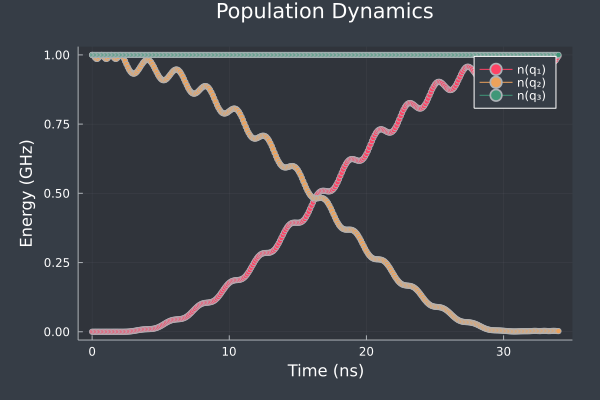

In [121]:
plot(title = "Population Dynamics", xlabel = "Time (ns)", ylabel = "Energy (GHz)"; plot_args...)
plot!(ts, res[!,"n(q₁)"] , label = "n(q₁)";  plot_args...)
plot!(ts, res[!,"n(q₂)"] , label = "n(q₂)";  plot_args...)
plot!(ts, res[!,"n(q₃)"] , label = "n(q₃)";  plot_args...)

### Turn on the interactions on the other two modes

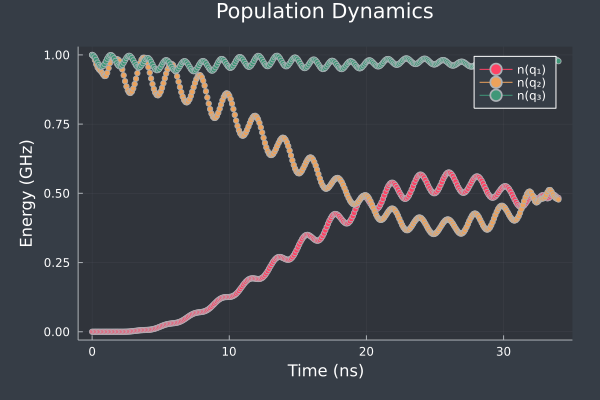

In [122]:
ωq₁ = 4.15 * GHz
ωc₁ = ωc_gate
ωq₂ = 4.15 * GHz
ωc₂ = ωc_idle + 200 * MHz
ωq₃ = 3.85 * GHz

ω⃗ = [ωq₁, ωc₁, ωq₂, ωc₂, ωq₃]

#define a vector of observables and create the `Observer`.
observables = [
    "n(q₁)" => ψ -> expect(ψ, "n"; sites = q₁), 
    "n(c₁)" => ψ -> expect(ψ, "n"; sites = c₁),
    "n(q₂)" => ψ -> expect(ψ, "n"; sites = q₂),
    "n(c₂)" => ψ -> expect(ψ, "n"; sites = c₂),
    "n(q₃)" => ψ -> expect(ψ, "n"; sites = q₃)
]

Ht = [hamiltonian([ωq₁, pulse_c, pulse_q₂, ωc₁, ωq₃], α⃗, t) for t in ts]

# build the Trotter circuit
circuit = trottercircuit(Ht; ts = ts, layered = true)

# set initial state |ψ⟩ = |0,1⟩
ψ₀ = productstate(hilbert, [0,0,1,0,1])

obs = observer(observables)

# perform TEBD simulation and generate output `MPS`
ψ = runcircuit(ψ₀, circuit; 
    cutoff = 1e-6,
    (observer!) = obs, 
    move_sites_back_before_measurements = true, 
    outputlevel = 0)

res = DataFrame(results(obs))

plot(title = "Population Dynamics", xlabel = "Time (ns)", ylabel = "Energy (GHz)"; plot_args...)
plot!(ts, res[!,"n(q₁)"] , label = "n(q₁)";  plot_args...)
plot!(ts, res[!,"n(q₂)"] , label = "n(q₂)";  plot_args...)
plot!(ts, res[!,"n(q₃)"] , label = "n(q₃)";  plot_args...)